# Performing Addition in Quantum Computers



## Classical Adder

## Quantum Adder



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

token = ""
shots = 100_000
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.least_busy(simulator=False, operational=True)

print(f"Chosen Backend: {backend.name}")

Chosen Backend: ibm_brisbane


In [2]:
def find_num_qubits(bits: int) -> int:
    return bits * 3 + 1

def initialize(qc: QuantumCircuit, bits: int, a: int, b: int) -> None:
    a_bin = bin(a)[2:].zfill(bits)
    b_bin = bin(b)[2:].zfill(bits)

    for i, char in enumerate(a_bin):
        if char == '1':
            qc.x(3*i+1)
    for i, char in enumerate(b_bin):
        if char == '1':
            qc.x(3*i+2)

def sum(qc: QuantumCircuit, index: int) -> None:
    qc.cx(index+1, index+2)
    qc.cx(index, index+2)

def carry(qc: QuantumCircuit, index: int) -> None:
    qc.ccx(index+1, index+2, index+3)
    qc.cx(index+1, index+2)
    qc.ccx(index, index+2, index+3)

def carry_dag(qc: QuantumCircuit, index: int) -> None:
    qc.ccx(index, index+2, index+3)
    qc.cx(index+1, index+2)
    qc.ccx(index+1, index+2, index+3)

def adder(bits: int, a: int, b: int) -> QuantumCircuit:
    num_qubits = find_num_qubits(bits)
    qc = QuantumCircuit(num_qubits, bits)

    initialize(qc, bits, a, b)

    for i in range(bits):
        carry(qc, 3*i)

    qc.cx(3*(bits-1)+1, 3*(bits-1)+2)
    sum(qc, 3*(bits-1))
    
    for i in range(bits-1, -1, -1):
        carry_dag(qc, 3*i)
        sum(qc, 3*i)

    qc.measure_all()
    
    return qc

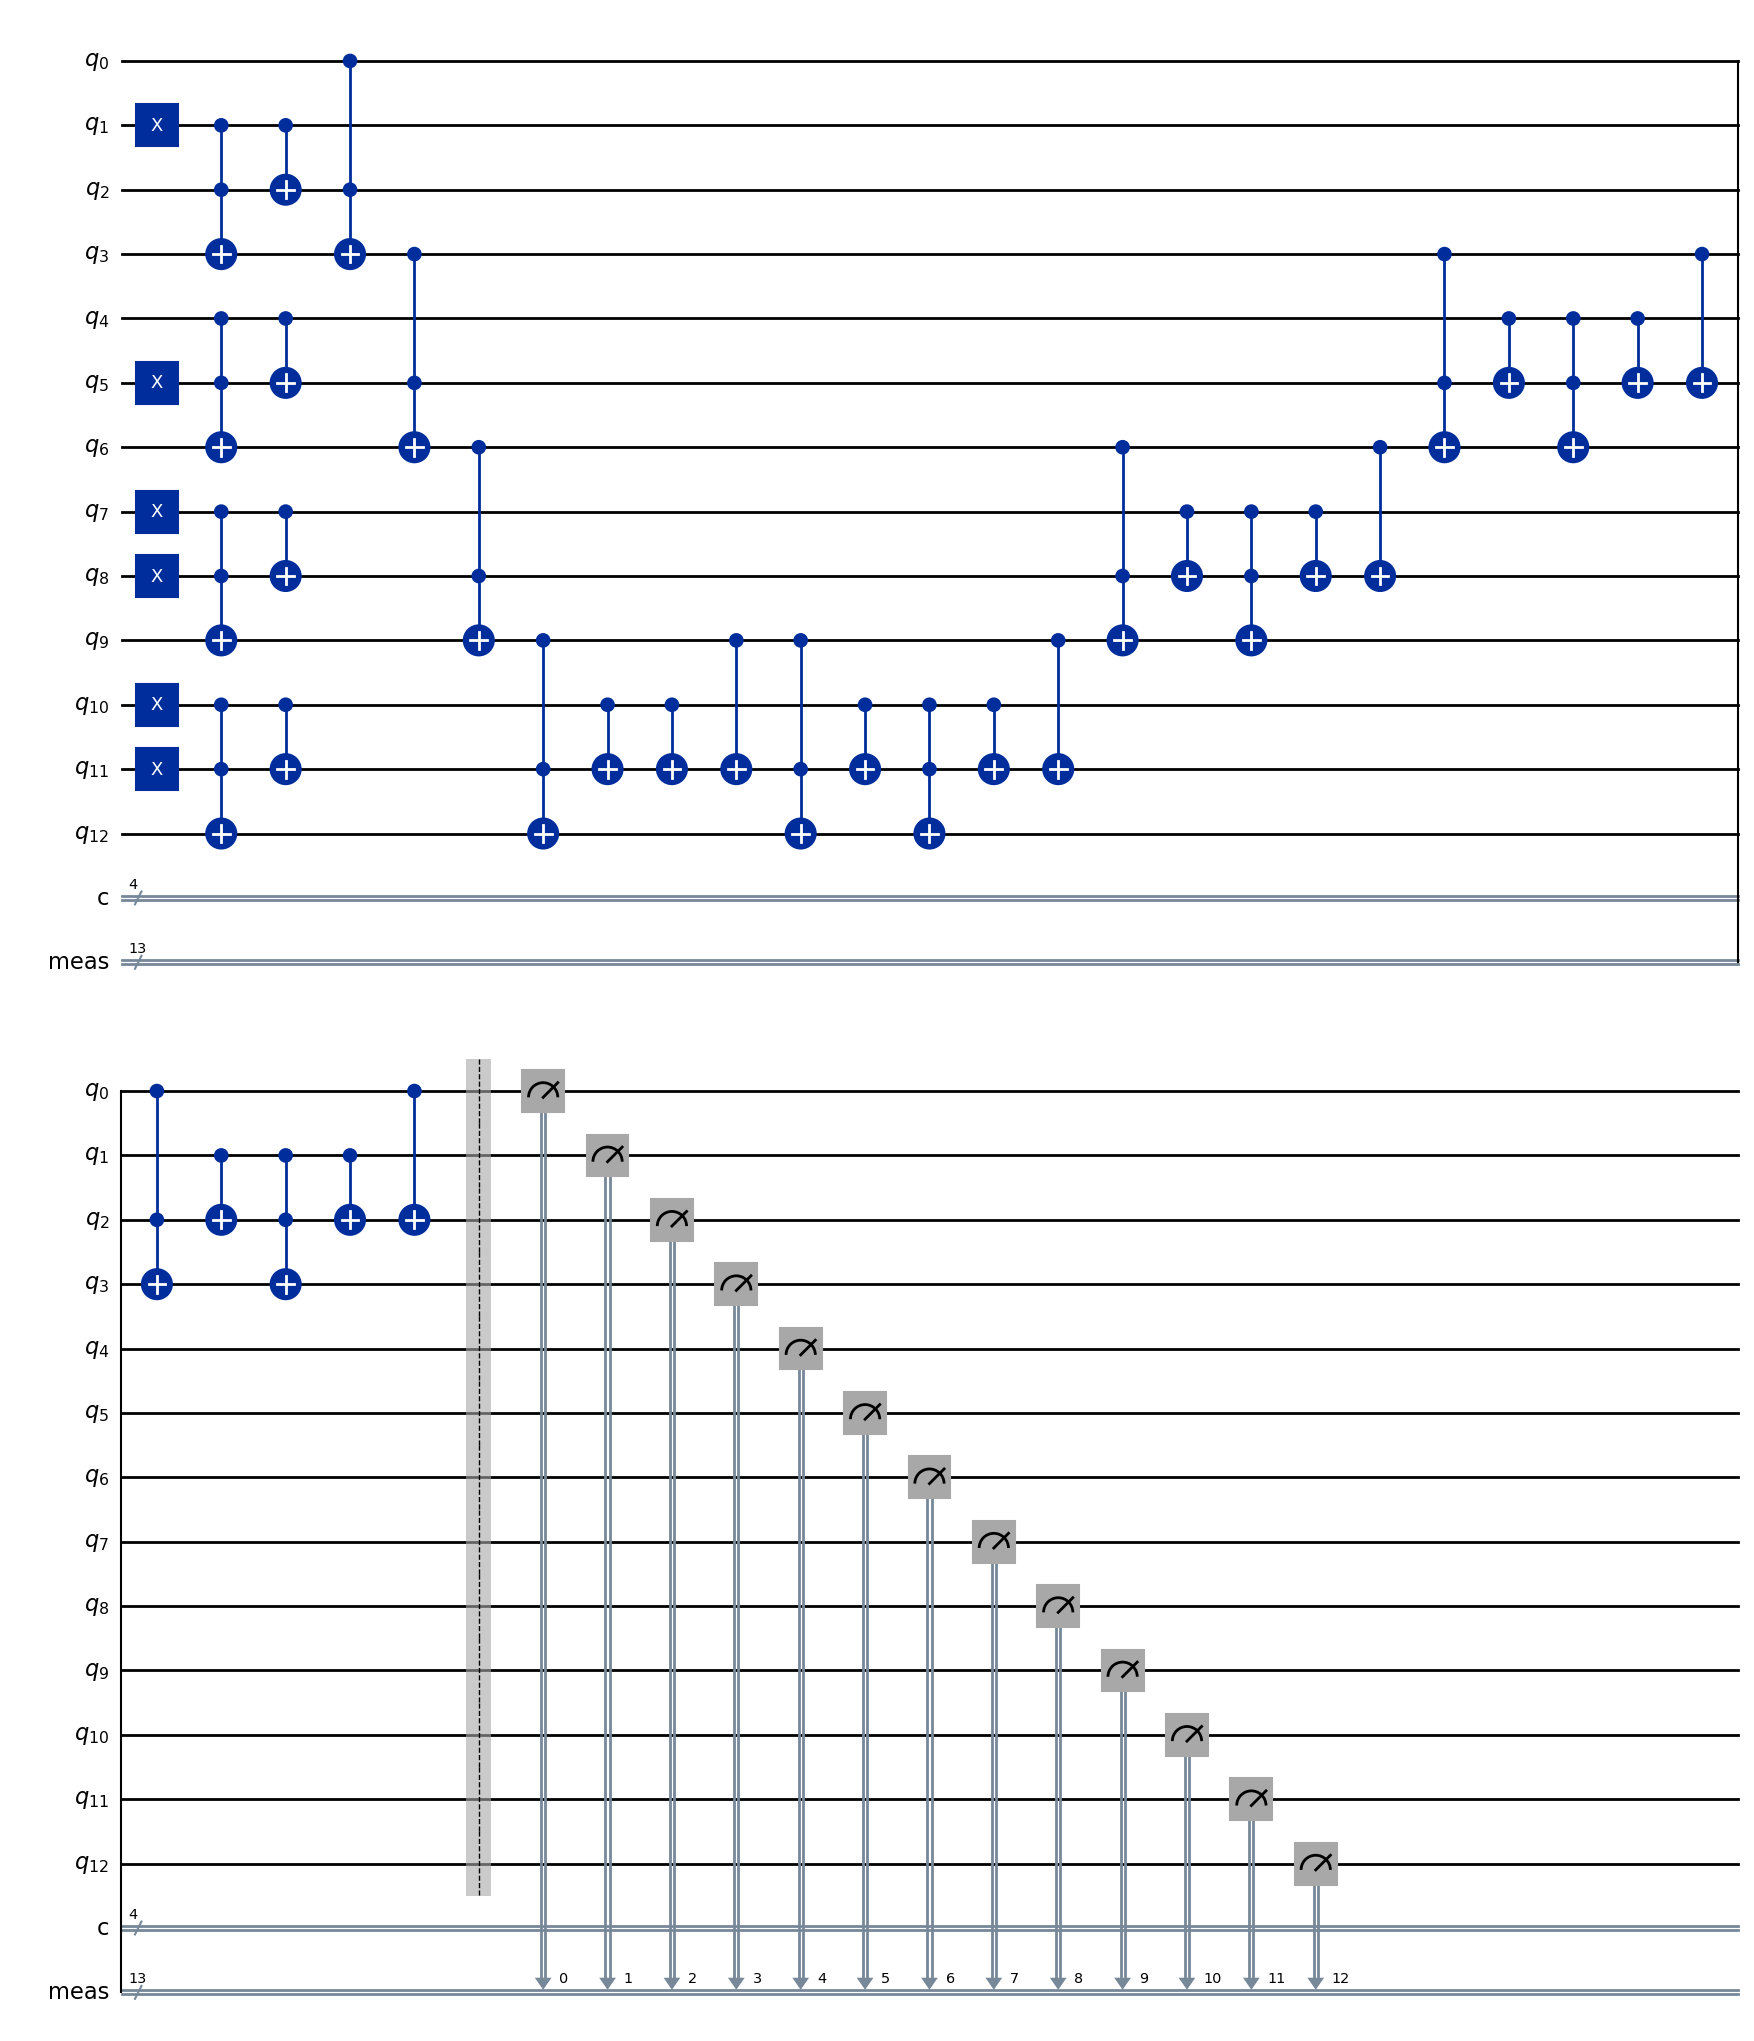

In [3]:
bits = 4
qubits = find_num_qubits(bits)
qc = QuantumCircuit(qubits)

a = 11
b = 7

adder_circuit = adder(bits, a, b)
adder_circuit.draw('mpl')

In [4]:
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_circuit = pass_manager.run(adder_circuit)
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_circuit], shots=shots)
result = job.result()

In [5]:
meas_dict = result[0].data.meas.get_counts()
max_key = max(meas_dict, key=meas_dict.get)

sum_str = max_key[0]
for i in range(bits):
    sum_str += max_key[i]

print(f"              Sum: {int(sum_str, 2)}")
print(f"         Expected: {a+b}")

print(f"     Sum (Binary): {sum_str}")
print(f"Expected (Binary): {bin(a+b)[2:].zfill(bits+1)}")

              Sum: 26
         Expected: 18
     Sum (Binary): 11010
Expected (Binary): 10010


## Quantum Adder in Superposition



## References